In [1]:
%matplotlib notebook
import mne
import matplotlib.pyplot as plt

fname = "oddball_example_small-fif.gz"

# Read in raw data; raw objects

In [3]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz...
This filename (C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz


<ipython-input-3-78767f98f250>:1: RuntimeWarning: This filename (C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.


MNE is *object oriented*. Objects have corresponding methods. Check which by typing `raw.` and pressing TAB:

In [ ]:
raw.

    raw.resample
    raw.filter
    raw.drop_channels
    ...

Can we do further preprocessing?..

In [4]:
raw.filter(1, 20)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. raw.filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

Aha! By default, MNE does not store raw and epochs objects in memory.

In [5]:
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz...
This filename (C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz


<ipython-input-5-7341ee706cdd>:1: RuntimeWarning: This filename (C:\Users\Aylin\Desktop\MNE workshop\oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.
Reading 0 ... 109097  =      0.000 ...  1090.970 secs...


In [6]:
raw.filter(1, 20)

Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 331 samples (3.310 sec) selected


<Raw  |  oddball_example_small-fif.gz, n_channels x n_times : 64 x 109098 (1091.0 sec), ~53.4 MB, data loaded>

Inspecting raw data ...

<IPython.core.display.Javascript object>


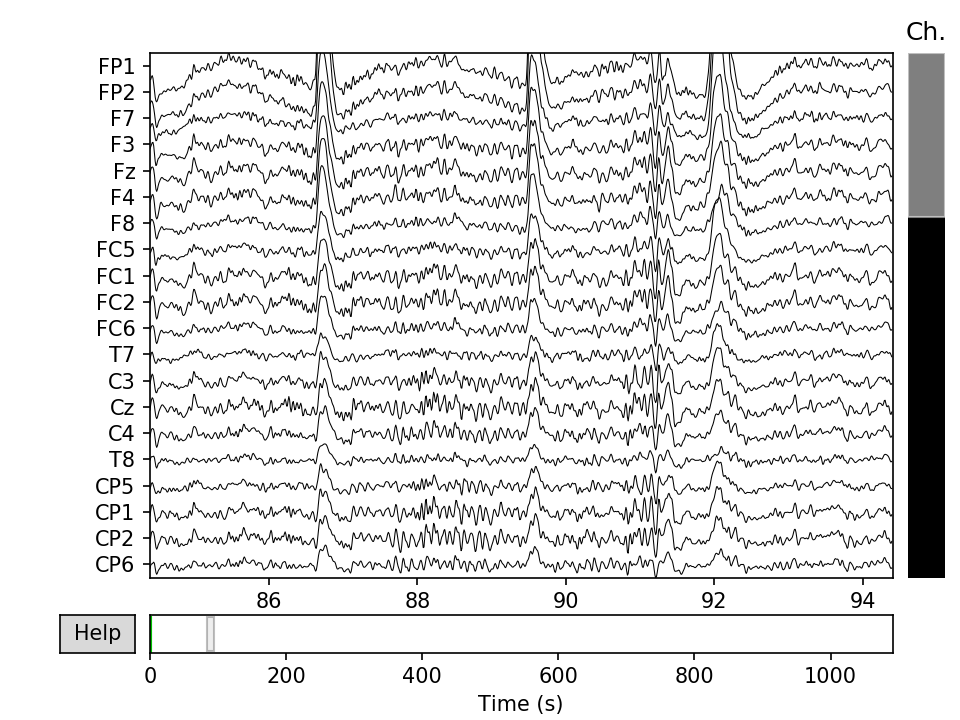

In [7]:
raw.plot();

There are many eog artefacts. We will use ICA to correct these. For this, we create an ICA object
and use its `.fit` method on a filtered copy of the raw data:

In [8]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)

In [9]:
ica.fit(raw.copy().filter(8, 35)) #hochpassfiltern von Kopie von Daten, ICA geht von stationären Komponenten aus, Komponenten 
                                    # verändern sich aber über die Zeit -driften. Deswegen hochpassfiltern

Setting up band-pass filter from 8 - 35 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 8.8 Hz
Filter length of 165 samples (1.650 sec) selected
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 4.8s.


<ICA  |  raw data decomposition, fit (fastica): 109098 samples, 20 components, channels used: "eeg">

<IPython.core.display.Javascript object>


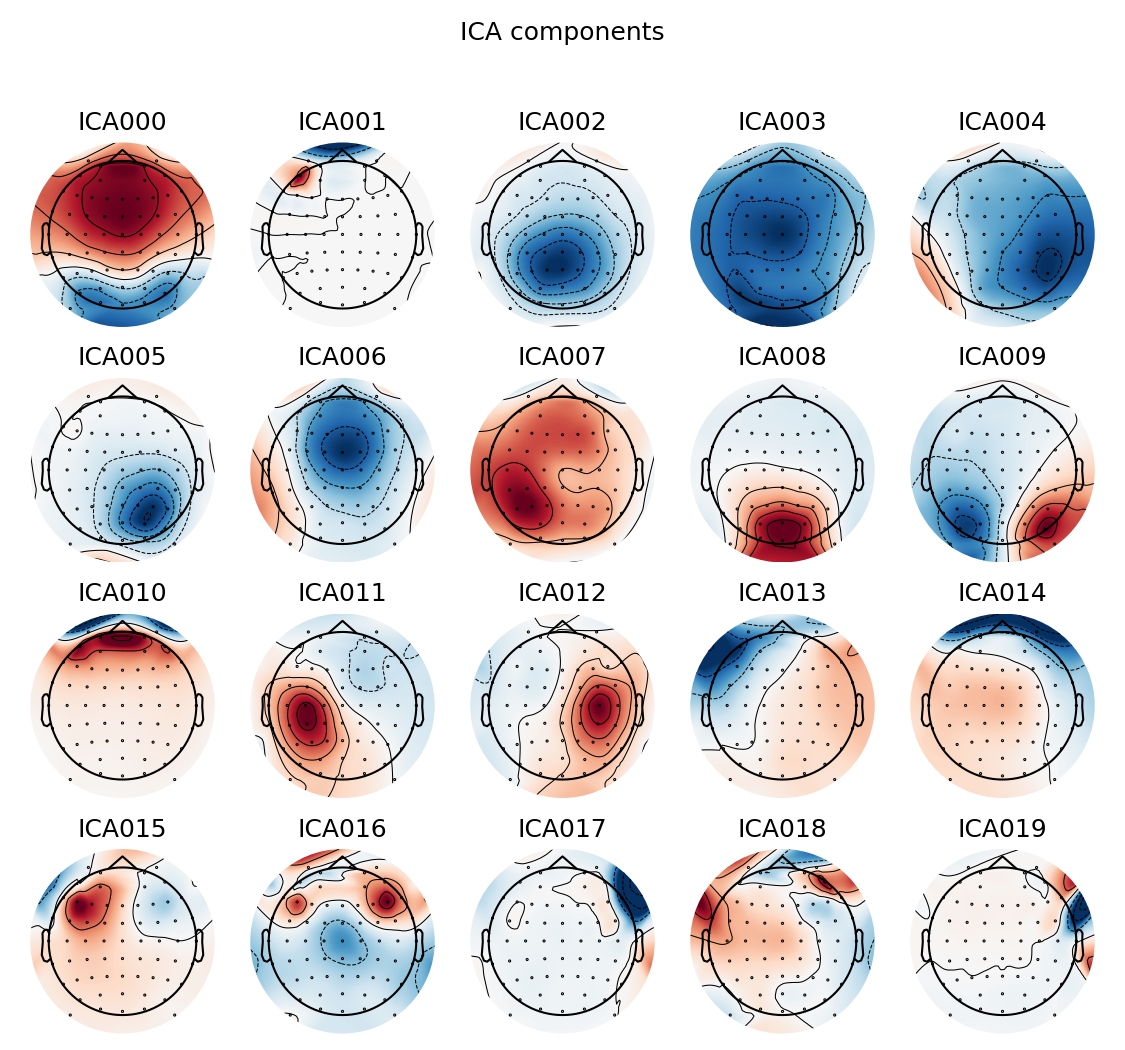

In [12]:
ica.plot_components(outlines="skirt"); #plottet die "Faktorladungen". ICA 10 ist blinzeln, positiv-negativ oben-unten
                                        # ICA 13 alpha Wellen
                                        # ICA 0 bilateraler occipitaler Dipol 

We store "bad" components in the ica object.

In [13]:
ica.exclude = [1, 10, 14, 17, 18, 19] #Artifakte rausnehmen, Liste aus Komponenten die wir nicht im Signal haben wollen

We could also use one of the automatic algorithms ...

In [14]:
bad_idx, scores = ica.find_bads_eog(raw, 'SO2', threshold=2)
print(bad_idx)

Using channel SO2 as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 1024 samples (10.240 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 1024 samples (10.240 sec) selected
[14, 10]


Let's compare raw and corrected data ...

<IPython.core.display.Javascript object>


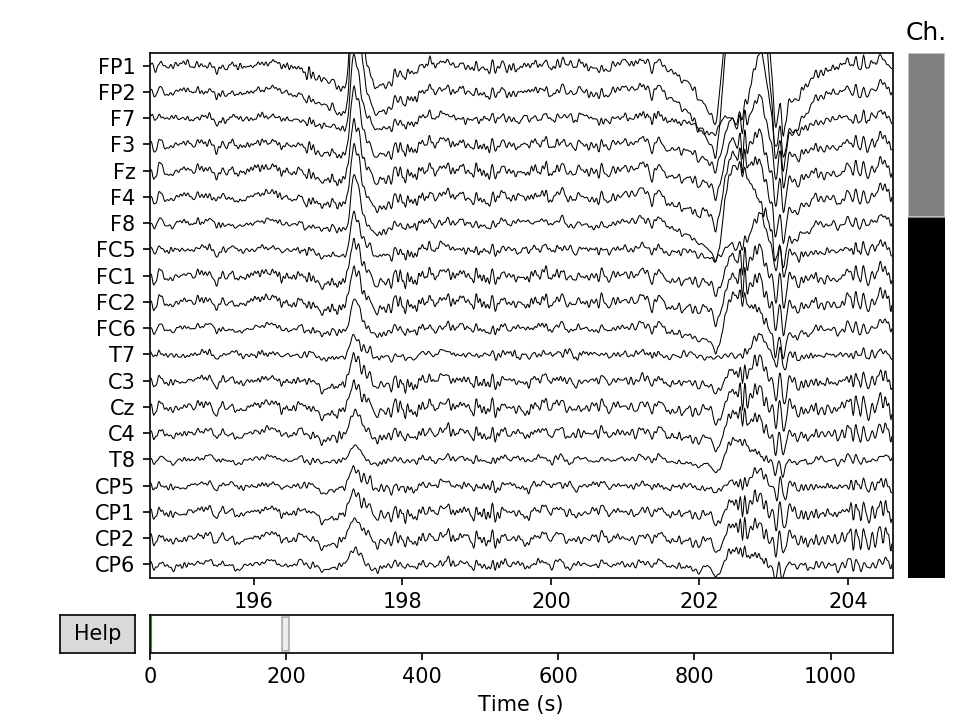

In [15]:
raw.plot();

Transforming to ICA space (20 components)
Zeroing out 6 ICA components


<IPython.core.display.Javascript object>


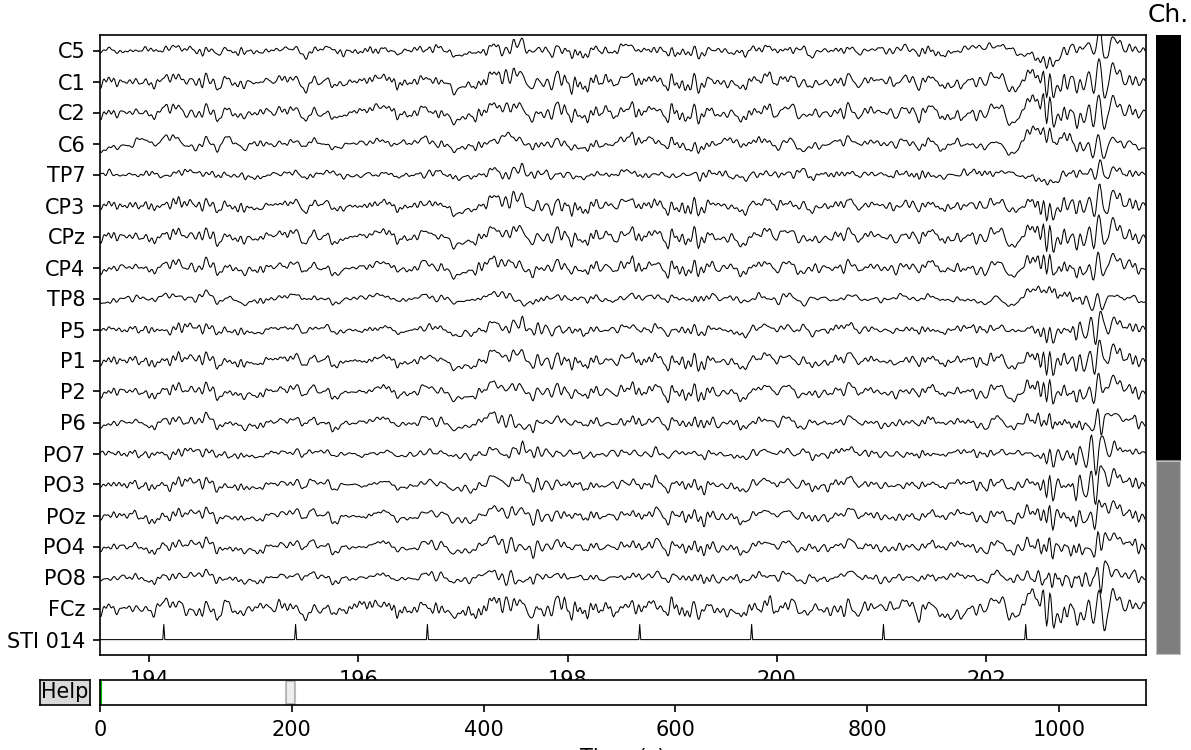

In [16]:
ica.apply(raw.copy(), exclude=ica.exclude).plot();

## Epochs

For epoching the data, we need event markers. Usually, these are stored in the `raw` object;
in MNE, in a stimulus channel.

In [17]:
events = mne.find_events(raw)

903 events found
Event IDs: [100 200]


`events` is simply an array (time in samples, zero, trigger);

In [18]:
events

array([[  3241,      0,    200],
       [  3437,      0,    200],
       [  3643,      0,    200],
       ...,
       [111496,      0,    200],
       [111613,      0,    200],
       [111719,      0,    200]], dtype=int64)

... which we can visualize:

<IPython.core.display.Javascript object>


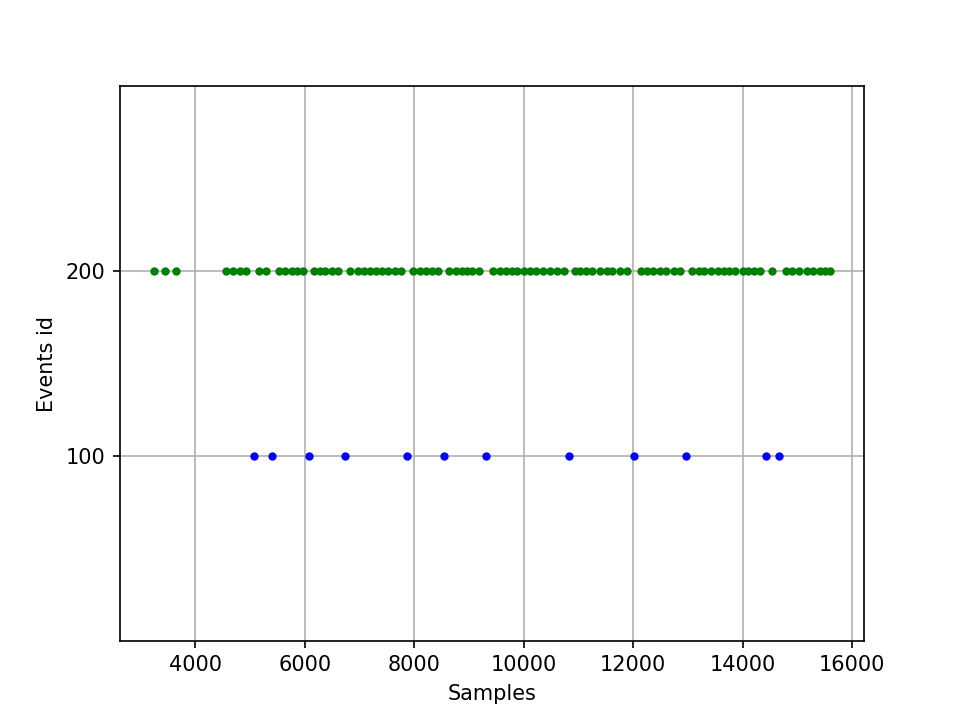

In [19]:
mne.viz.plot_events(events[:100]);

For creating an `mne.Epochs` object, we require, in addition to the `raw` object and the `events` array, a dictionary of the intended condition names and the corresponding trigger numbers.

In [21]:
event_ids = {"standard/stimulus": 200, "target/stimulus": 100}

epochs = mne.Epochs(raw, events, event_id=event_ids)

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 903 events and 71 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


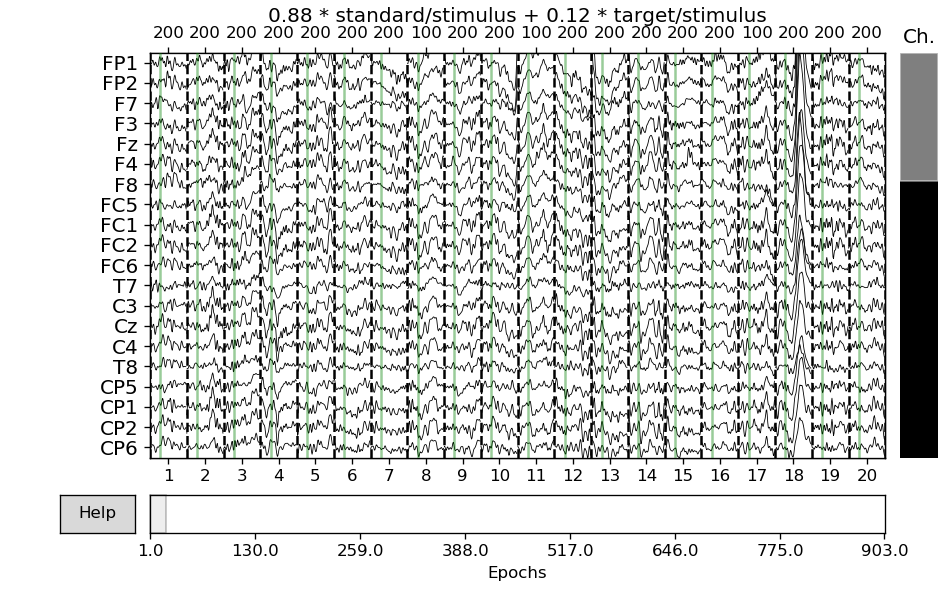

Loading data for 20 events and 71 original time points ...


In [22]:
epochs.plot();

(changing to the inline backend now to speed things up.)

In [23]:
%matplotlib inline

Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []


In [24]:
epochs = ica.apply(epochs, exclude=ica.exclude)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. ica.apply requires epochs data to be loaded. Use preload=True (or string) in the constructor or epochs.load_data().

Of course ...

In [25]:
epochs = mne.Epochs(raw, events, event_id=event_ids, preload=True)
epochs = ica.apply(epochs, exclude=ica.exclude)

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 903 events and 71 original time points ...
0 bad epochs dropped
Transforming to ICA space (20 components)
Zeroing out 6 ICA components


The `mne.Epochs` constructor has a number of options, such as time window lengths and rejection thresholds.
Investigate them on your own.

`Epochs` objects also have various methods, different from `raw` objects - e.g., for baselining.

In [26]:
epochs.apply_baseline((None, 0)) #averaged den zeitpunkt for dem epoch als baseline

Applying baseline correction (mode: mean)


<Epochs  |   903 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~31.4 MB, data loaded,
 'standard/stimulus': 797
 'target/stimulus': 106>

... and many more ...

In [ ]:
epochs.

To subselect only a sample of epochs, a dict-like access mode is available.

In [27]:
epochs["target"] # slashes "/" gruppieren für faktorielle Designs. 

<Epochs  |   106 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~3.8 MB, data loaded,
 'target/stimulus': 106>

Observe how tags selected by forward slashes - "/" - work.

In [28]:
epochs["stimulus"]

<Epochs  |   903 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~31.4 MB, data loaded,
 'standard/stimulus': 797
 'target/stimulus': 106>

How does the epoched activity look like?

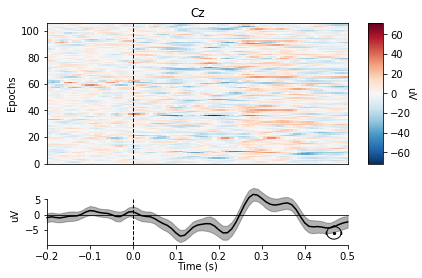

In [29]:
epochs["target"].plot_image(picks=[13]); # channel nummer 13

To ensure we have as many Oddball as Standard trials, we can run ...

In [30]:
epochs.equalize_event_counts(event_ids)#gleich viele Trials enthalten
epochs

Dropped 691 epochs


<Epochs  |   212 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~7.5 MB, data loaded,
 'standard/stimulus': 106
 'target/stimulus': 106>

We can write the Epochs object to disk so we don't have to repeat the
preprocessing later ...

In [31]:
epochs.save("oddball-epo.fif")  # remember, the data has been cleaned of bad ICs

In [32]:
epochs_for_tfr = mne.Epochs(raw, events, event_id=event_ids,
                            tmin=-.5, tmax=1.5, preload=True)  # need longer data segment
epochs_for_tfr = ica.apply(epochs_for_tfr, exclude=ica.exclude)
epochs_for_tfr.equalize_event_counts(event_ids);  # to speed up things
epochs_for_tfr.save("oddball-long-epo.fif")

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 903 events and 201 original time points ...
0 bad epochs dropped
Transforming to ICA space (20 components)
Zeroing out 6 ICA components
Dropped 691 epochs
